# **Alternative Splicing  Heatplot**
This notebook generates a heat plot representing sex-biased differential gene expression as well as a plot showing the counts of differentially expressed genes per tissue.

The values in the heatmap represent the correlation (similarity in the fold-changes) between male and female samples, with the values in the heatmap being the correlation between the vectors of fold changes of the tissues.

The assumptions made before rendering the heatmaps 
1. Get differential gene expression (DGE) files
2. Use the ``../assets/tissues.tsv`` to limit the tissues to those with at least 50 samples in each sex (``tissues.tsv`` was produced by a Python script)
3. Use the pattern for the differentially expressed genes **"../data/*_AS_model_B_sex_as_events.csv"** to get all the values for the matrix.

## **Running this notebook**:

See the README for setting up prerequisites for the notebook.

## 1. Setup 

Assumes the `countGenesAndEvents.ipynb` notebook was run -- unpacking the results from the differential Gene Expression Analysis as run in the `differentialAlternativeSplicingJunctionAnalysis.ipynb` notebook.

In [1]:
defaultW <- getOption("warn")  # suppress warnings for this cell
options(warn = -1) 

library(stringr)
library(edgeR)
library(pheatmap)
library(magrittr)
library(dplyr)
library(ggplot2)
library(scales)
library(viridis)
library(scales)

Sys.setenv(TAR = "/bin/tar") # for gzfile

options(warn = defaultW)

Loading required package: limma


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: viridisLite


Attaching package: ‘viridis’


The following object is masked from ‘package:scales’:

    viridis_pal




## 2. Making the matrices

### 2.1 Read in all the alternative Splicing Junction Analysis results

Start with the Skipped Exon alternative Splicing Junction Analysis results

In [2]:
results_dir <- "../data/"
pattern     <- "_AS_model_B_sex_as_events_refined.csv"
#pattern     <- "_AS_model_A_ijc_sex_refined.csv"
files       <- list.files(path = results_dir, pattern = pattern)
message("Number of se AS files found with se_*AS_model_B_sex_as_events_refined.csv pattern: ",
        length(files))
se_files <- files[grepl("^se_", files)]
length(se_files)

Number of se AS files found with se_*AS_model_B_sex_as_events_refined.csv pattern: 195



[1] 39

### 2.2 read in the curated "../assets/tissues.tsv" 

The **`../assets/tissues.tsv`** file contains an indication to include the tissue if the file has at least **50** samples in that tissue with either **male** or **female** sex reporting

In [3]:
# read in all requirements so that the stage is properly set -- 
# if it is clear here -- it will remain clear for the rest of the time
# tissues.tsv contains the subset of files desired for analysis.
tissue_reduction <- read.table(file="../assets/tissues.tsv", header=TRUE, sep="\t",
                               skipNul=FALSE, stringsAsFactors = FALSE)
colnames(tissue_reduction)  <- c("SMTSD","female","male","include","display_name")
tissue_reduction$SMTSD <- factor(snakecase::to_snake_case(as.character(tissue_reduction$SMTSD)))
# only include those tissues we wish to continue with
table(tissue_reduction$include)
tissue_reduction <- tissue_reduction[tissue_reduction$include==1,]

message("Number of tissues with >=50 samples each in ../assets/tissues.tsv (tissue_reduction)",
        paste(dim(tissue_reduction), collapse=" "))


 0  1 
11 39 

Number of tissues with >=50 samples each in ../assets/tissues.tsv (tissue_reduction)39 5



### 2.3 model rownames from fromGTF files

Arbitrarily using the first file, to obtain the ordered rownames for assignment to the remainder of the files in the construction of the matrix.

In [4]:
a3ss_annot <- read.table(file = "../data/fromGTF.A3SS.txt", sep = "\t", quote = "\"", header = T, stringsAsFactors = F)
a5ss_annot <- read.table(file = "../data/fromGTF.A5SS.txt", sep = "\t", quote = "\"", header = T, stringsAsFactors = F)
mxe_annot <- read.table(file = "../data/fromGTF.MXE.txt", sep = "\t", quote = "\"", header = T, stringsAsFactors = F)
ri_annot <- read.table(file = "../data/fromGTF.RI.txt", sep = "\t", quote = "\"", header = T, stringsAsFactors = F)
se_annot <- read.table(file = "../data/fromGTF.SE.txt", sep = "\t", quote = "\"", header = T, stringsAsFactors = F)

### 2.4 make a new column combining idx with geneSymbol

all of the model_B toptable events are annotated with **geneSymbol-alternativeSplicingEventID**.  These are alternative Splicing Event specific.   So we will have a matrix per alternative splicing event.

In [5]:
a3ss_annot$geneASID <- as.character(paste(a3ss_annot$geneSymbol, a3ss_annot$ID, sep="-"))
a5ss_annot$geneASID <- as.character(paste(a5ss_annot$geneSymbol, a5ss_annot$ID, sep="-"))
mxe_annot$geneASID  <- as.character(paste(mxe_annot$geneSymbol,  mxe_annot$ID, sep="-"))
ri_annot$geneASID   <- as.character(paste(ri_annot$geneSymbol,   ri_annot$ID, sep="-"))
se_annot$geneASID   <- as.character(paste(se_annot$geneSymbol,   se_annot$ID, sep="-"))


### 2.5 Heatmap gene-junction ids are union of events from all tissues

In [6]:
genesids <- data.frame()
fullfilename  <- paste0("../data/",se_files[1])
logFC_result  <- read.csv(fullfilename)
filegenesids  <- as.character(rownames(logFC_result))
genesids      <- filegenesids

for (i in 2:length(se_files)) {
    fullfilename  <- paste0("../data/",se_files[i])
    logFC_result  <- read.csv(fullfilename)
    filegenesids  <- as.character(rownames(logFC_result))
    genesids      <- union(genesids,filegenesids)
}
length(se_files)
idx <- order(genesids)
genesids <- genesids[idx]
length(genesids)
head(genesids)

[1] 39

[1] 3992

[1] "AASS-23521"   "ABCA10-25861" "ABCA10-25867" "ABCA2-3039"   "ABCA7-17083" 
[6] "ABCA7-17084"

### 2.7 With the union of gene-junction ids make a matrix of logFC and adjusted pValue data

In [7]:
files <- se_files
logFC_mat <- matrix(0.0, nrow=length(genesids), ncol = length(files))
pVal_mat  <- logFC_mat
rownames(logFC_mat) <- as.character(genesids)
for (i in 1:length(files)) {
    fullfilename  <- paste0("../data/",files[i])
    logFC_result  <- read.csv(fullfilename)
    filegenesids  <- as.character(rownames(logFC_result))
    for (j in 1:length(filegenesids)) {
        genesids_match <- genesids %in% filegenesids[j]
        logFC_mat[genesids_match==TRUE,i] <- logFC_result[filegenesids[j],"logFC"]
        pVal_mat [genesids_match==TRUE,i] <- logFC_result[filegenesids[j],"adj.P.Val"]
    }
}

mat_colnames = files
for (i in 1:length(mat_colnames)) {
    mat_colnames[i] <- gsub(pattern,"", mat_colnames[i], fixed = TRUE)
    mat_colnames[i] <- substring(mat_colnames[i],4)
}

display_name = ifelse(mat_colnames == tissue_reduction$SMTSD, 
                                      tissue_reduction$display_name,
                                      mat_colnames)
colnames(logFC_mat) <- as.character(display_name)
colnames(pVal_mat)  <- as.character(display_name)

### 2.8 Reduce the matrix to only those that pass FC > 1.5 and <= adjusted pVal < 0.05

Remove the cells in the matrix that are <= abs(log2(1.5)) preserving only the values that are FC >= 1.5 and adj.P.Val <= 0.05 (from a separate but coordinated matrix.

In [8]:
logFC_ct <- rowSums(abs(logFC_mat) >= log2(1.5))
pVal_ct  <- rowSums(pVal_mat <= 0.05)

logFC_pass <- logFC_ct>1
table(logFC_pass)
pVal_pass  <-  pVal_ct>1
table(pVal_pass)

logFC_pVal_pass <- logFC_ct & pVal_ct
table(logFC_pVal_pass)

id <- logFC_pVal_pass

logFC_gt_1.5 <- logFC_mat[id,]

dim(logFC_gt_1.5)
head(logFC_gt_1.5)

logFC_pass
FALSE  TRUE 
 3759   233 

pVal_pass
TRUE 
3992 

logFC_pVal_pass
TRUE 
3992 

[1] 3992   39

,Adipose (sc),Adipose (v),Adrenal gland,Aorta,Coronary artery,Tibial artery,Caudate,Cerebellar hemisphere,Cerebellum,Cortex,⋯,Tibial nerve,Pancreas,Pituitary,Skin (not exposed),Skin (exposed),Small intestine,Spleen,Stomach,Thyroid,Whole blood
AASS-23521,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0.6064495,0,0,0,0,0
ABCA10-25861,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0.0000000,0,0,0,0,0
ABCA10-25867,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0.0000000,0,0,0,0,0
ABCA2-3039,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0.0000000,0,0,0,0,0
ABCA7-17083,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0.0000000,0,0,0,0,0
ABCA7-17084,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0.0000000,0,0,0,0,0


### 2.9 Calculate the correlation between the tissues using the logFC

Calculate the correlation distances between the tissues using the logFC within each of the tissues.   Clustering by similar expression.

In [9]:
# dist_mat all values logFC_mat
dist_mat <- as.matrix(cor(logFC_mat))

## 3. Render the heatmaps of the distance correlations

### 3.1 heatmap logFC

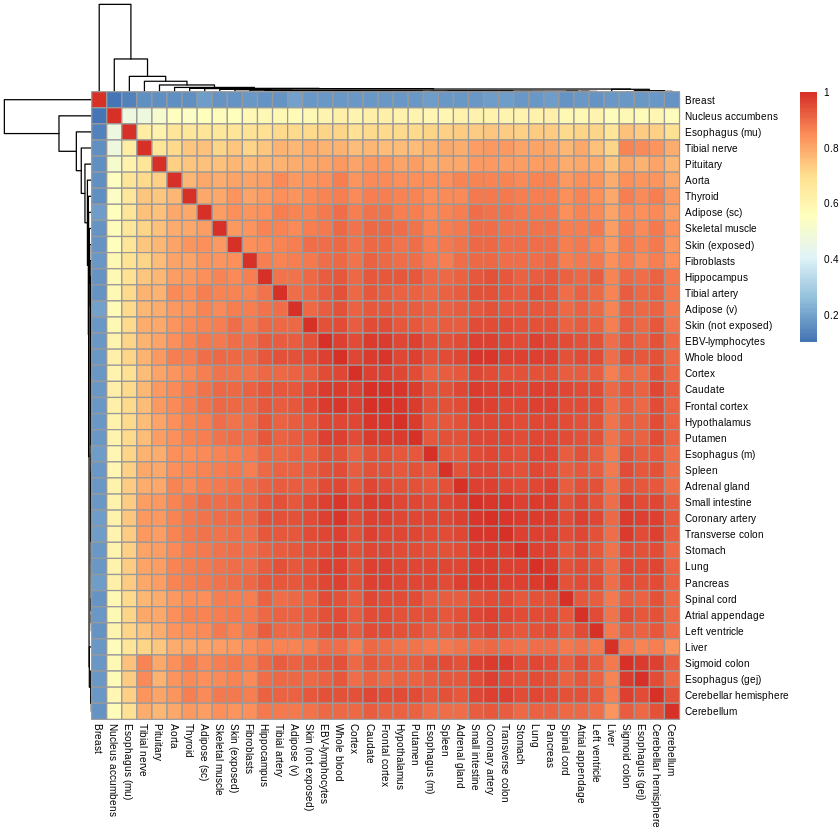

In [10]:
pheatmap(as.matrix(dist_mat), clustering_distance_rows = "correlation", clustering_distance_cols = "correlation", fontsize = 6)
hm.parameters <- list(dist_mat, fontsize = 6)
do.call("pheatmap", c(hm.parameters,  filename="../pdf/se_alternativeSplicingDistanceCorrelationHeatmapAlllogFC.pdf"))

### 3.2 heatmap normalize quantiles logFC_mat

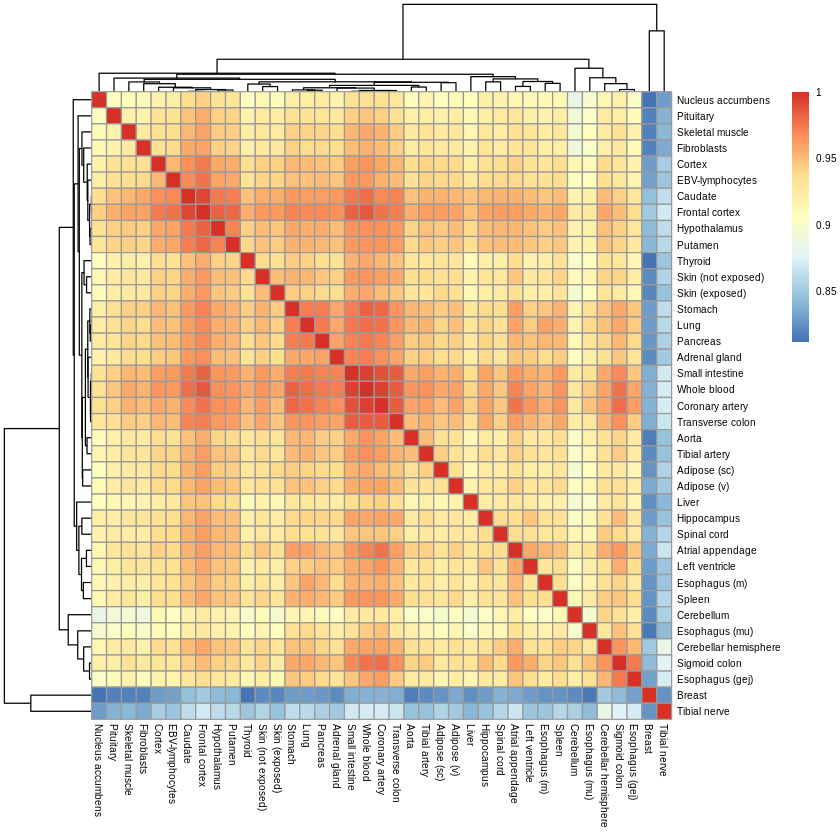

In [11]:
logFC_mat_NQ <- normalizeQuantiles(logFC_mat)
dist_mat <- as.matrix(cor(logFC_mat_NQ))
pheatmap(as.matrix(dist_mat), clustering_distance_rows = "correlation", clustering_distance_cols = "correlation", fontsize = 6)
hm.parameters <- list(dist_mat, fontsize = 6)
do.call("pheatmap", c(hm.parameters,  filename="../pdf/se_alternativeSplicingDistanceCorrelationAlllogFC_NQ.pdf"))

### 3.3 heatmap logFC >= 1.5 and adjusted p Value < 0.05

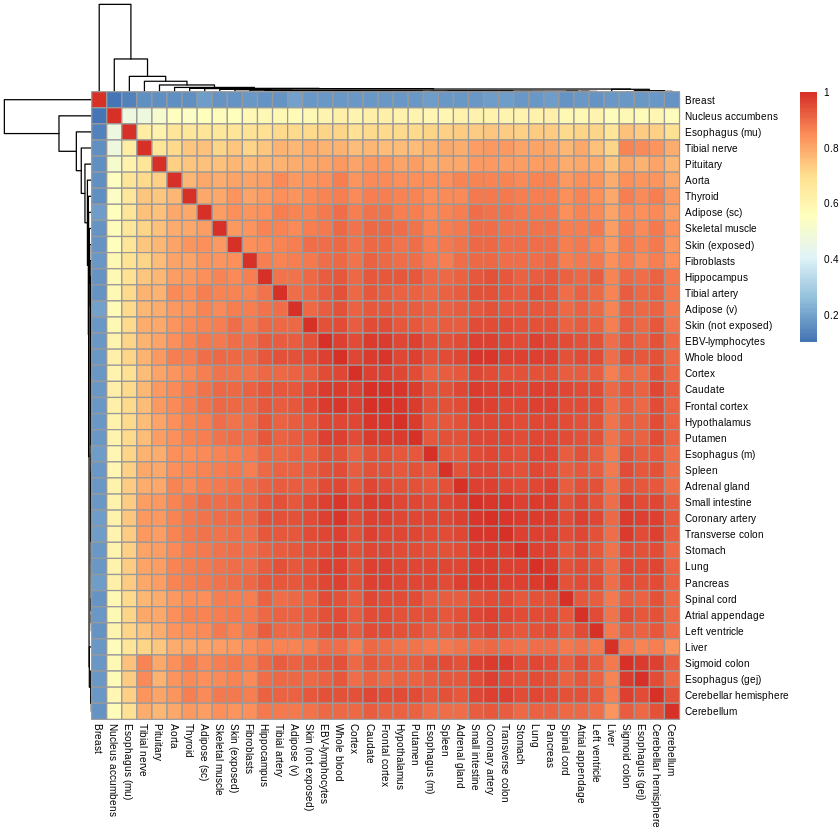

In [12]:
# dist_mat all values with logFC_mat_gt_1.5 
dist_mat <- as.matrix(cor(logFC_gt_1.5))
pheatmap(as.matrix(dist_mat), clustering_distance_rows = "correlation", clustering_distance_cols = "correlation", fontsize = 6)
hm.parameters <- list(dist_mat, fontsize = 6)
do.call("pheatmap", c(hm.parameters,  filename="../pdf/se_alternativeSplicingDistanceCorrelationHeatmapAlllogFC_gt_1.5.pdf"))

### 3.4 heatmap normalize quantiles logFC >= 1.5 and adjusted pValue < 0.05

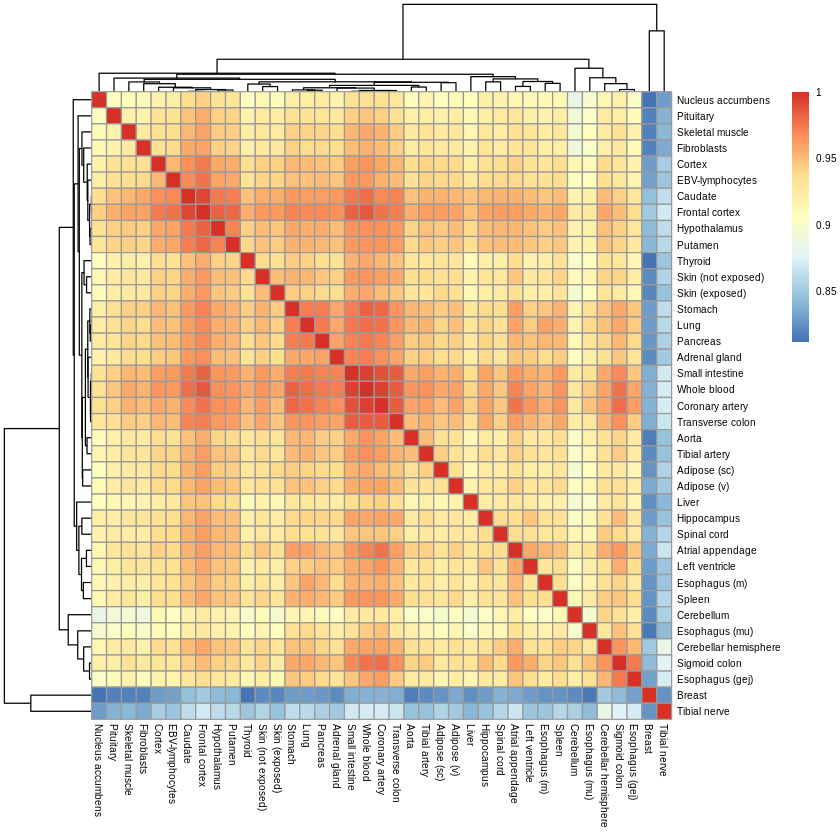

In [13]:
# dist_mat all values with logFC_gt_1.5_mat normalizeQuantiles 
logFC_mat_gt_1.5_NQ <- normalizeQuantiles(logFC_gt_1.5)
dist_mat <- as.matrix(cor(logFC_mat_gt_1.5_NQ))
pheatmap(as.matrix(dist_mat), clustering_distance_rows = "correlation", clustering_distance_cols = "correlation", fontsize = 6)
hm.parameters <- list(dist_mat, fontsize = 6)
do.call("pheatmap", c(hm.parameters,  filename="../pdf/se_alternativeSplicingCorrelationHeatmapAlllogFC_gt_1.5NQ.pdf"))


### 3.5 save the logFC_mat_gt_1.5_NQ rds object

In [15]:
rownames(dist_mat) <- colnames(logFC_mat_gt_1.5_NQ)
colnames(dist_mat) <- colnames(logFC_mat_gt_1.5_NQ)

message("Saving dist_mat object")
saveRDS(object = dist_mat, file = "../data/se_as_dist_mat.rds")
message("Done!")

Saving dist_mat object

Done!



## Appendix Metadata

For replicability and reproducibility purposes, we also print the following metadata:

### Appendix.1. Checksums with the sha256 algorithm
1. Checksums of **'artefacts'**, files generated during the analysis and stored in the folder directory **`data`**
2. List of environment metadata, dependencies, versions of libraries using `utils::sessionInfo()` and [`devtools::session_info()`](https://devtools.r-lib.org/reference/session_info.html)

In [16]:
figure_id   = "alternativeSplicingHeatmap"

### Appendix.2. Libraries

In [17]:
dev_session_info   <- devtools::session_info()
utils_session_info <- utils::sessionInfo()

message("Saving `devtools::session_info()` objects in ../metadata/devtools_session_info.rds  ..")
saveRDS(dev_session_info, file = paste0("../metadata/", figure_id, "_devtools_session_info.rds"))
message("Done!\n")

message("Saving `utils::sessionInfo()` objects in ../metadata/utils_session_info.rds  ..")
saveRDS(utils_session_info, file = paste0("../metadata/", figure_id ,"_utils_info.rds"))
message("Done!\n")

dev_session_info$platform
dev_session_info$packages[dev_session_info$packages$attached==TRUE, ]

Saving `devtools::session_info()` objects in ../metadata/devtools_session_info.rds  ..

Done!


Saving `utils::sessionInfo()` objects in ../metadata/utils_session_info.rds  ..

Done!




 setting  value                       
 version  R version 3.6.2 (2019-12-12)
 os       Ubuntu 18.04.3 LTS          
 system   x86_64, linux-gnu           
 ui       X11                         
 language en_US.UTF-8                 
 collate  en_US.UTF-8                 
 ctype    en_US.UTF-8                 
 tz       Etc/UTC                     
 date     2020-06-23                  

,package,ondiskversion,loadedversion,path,loadedpath,attached,is_base,date,source,md5ok,library
,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>,<chr>,<lgl>,<fct>
dplyr,dplyr,0.8.4,0.8.4,/opt/conda/lib/R/library/dplyr,/opt/conda/lib/R/library/dplyr,TRUE,FALSE,2020-01-31,CRAN (R 3.6.2),NA,/opt/conda/lib/R/library
edgeR,edgeR,3.28.0,3.28.0,/opt/conda/lib/R/library/edgeR,/opt/conda/lib/R/library/edgeR,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
ggplot2,ggplot2,3.2.1,3.2.1,/opt/conda/lib/R/library/ggplot2,/opt/conda/lib/R/library/ggplot2,TRUE,FALSE,2019-08-10,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
limma,limma,3.42.0,3.42.0,/opt/conda/lib/R/library/limma,/opt/conda/lib/R/library/limma,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
magrittr,magrittr,1.5,1.5,/opt/conda/lib/R/library/magrittr,/opt/conda/lib/R/library/magrittr,TRUE,FALSE,2014-11-22,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
pheatmap,pheatmap,1.0.12,1.0.12,/opt/conda/lib/R/library/pheatmap,/opt/conda/lib/R/library/pheatmap,TRUE,FALSE,2019-01-04,CRAN (R 3.6.3),NA,/opt/conda/lib/R/library
scales,scales,1.1.0,1.1.0,/opt/conda/lib/R/library/scales,/opt/conda/lib/R/library/scales,TRUE,FALSE,2019-11-18,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
stringr,stringr,1.4.0,1.4.0,/opt/conda/lib/R/library/stringr,/opt/conda/lib/R/library/stringr,TRUE,FALSE,2019-02-10,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
viridis,viridis,0.5.1,0.5.1,/opt/conda/lib/R/library/viridis,/opt/conda/lib/R/library/viridis,TRUE,FALSE,2018-03-29,CRAN (R 3.6.3),NA,/opt/conda/lib/R/library
